<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-team-1-1/blob/main/Project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Data Preparation**

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [12]:
# Data Loading
# (45211, 17)
df_train = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/train.csv", sep=";")
df_test = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/test.csv", sep=";")

In [13]:
# looking for missing data
print("Missing values found", df_train.isnull().sum())

# looking for duplicate data
print("Duplicates found: ", df_train.duplicated().sum())

Missing values found age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Duplicates found:  0


Even though the source has already stated that the data has no missing values or duplicates, it is still good to verify this, since these steps affect all the later processes.

 # Fix mixed-type categorical columns


In [14]:

cat_cols_train = df_train.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols_train:
    df_train[c] = df_train[c].astype(str)

cat_cols_test = df_test.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols_test:
    df_test[c] = df_test[c].astype(str)

## Numeric Features

In [15]:
numeric_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df_train.select_dtypes(include=["object"]).columns.tolist()

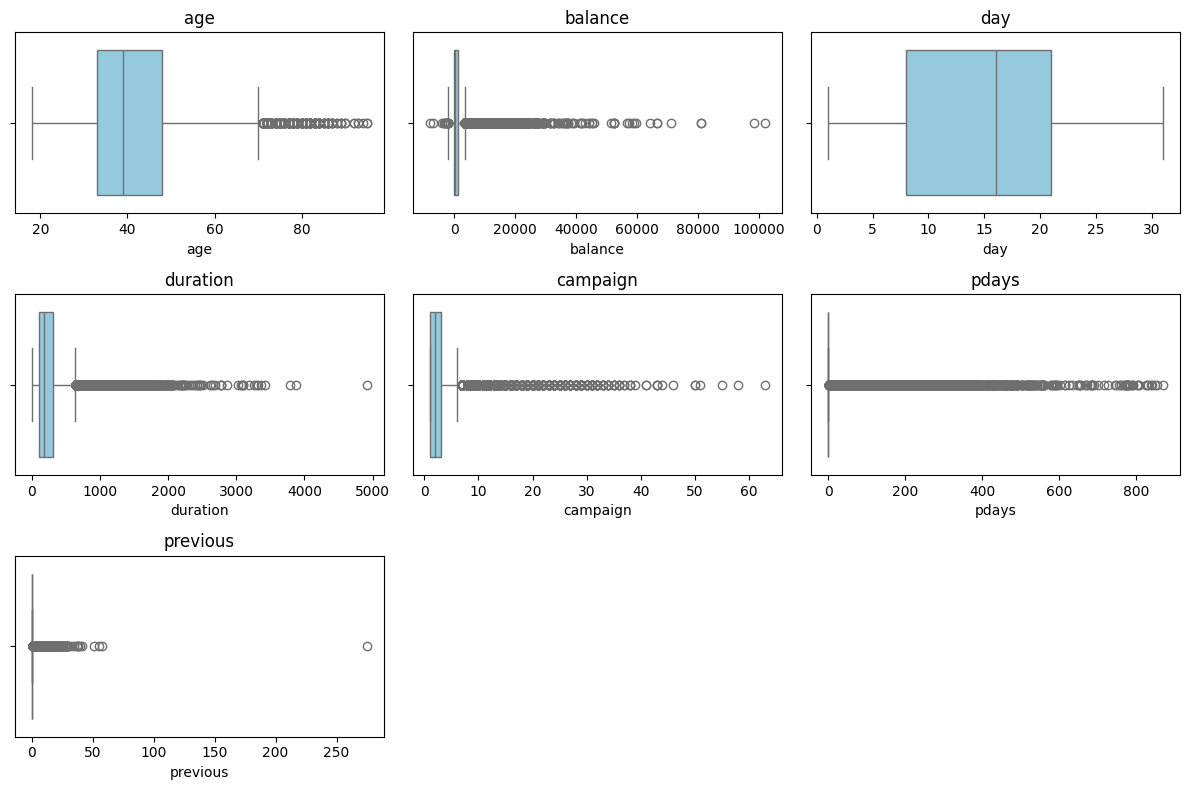

In [17]:
# Box plot
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df_train[col], color="skyblue")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

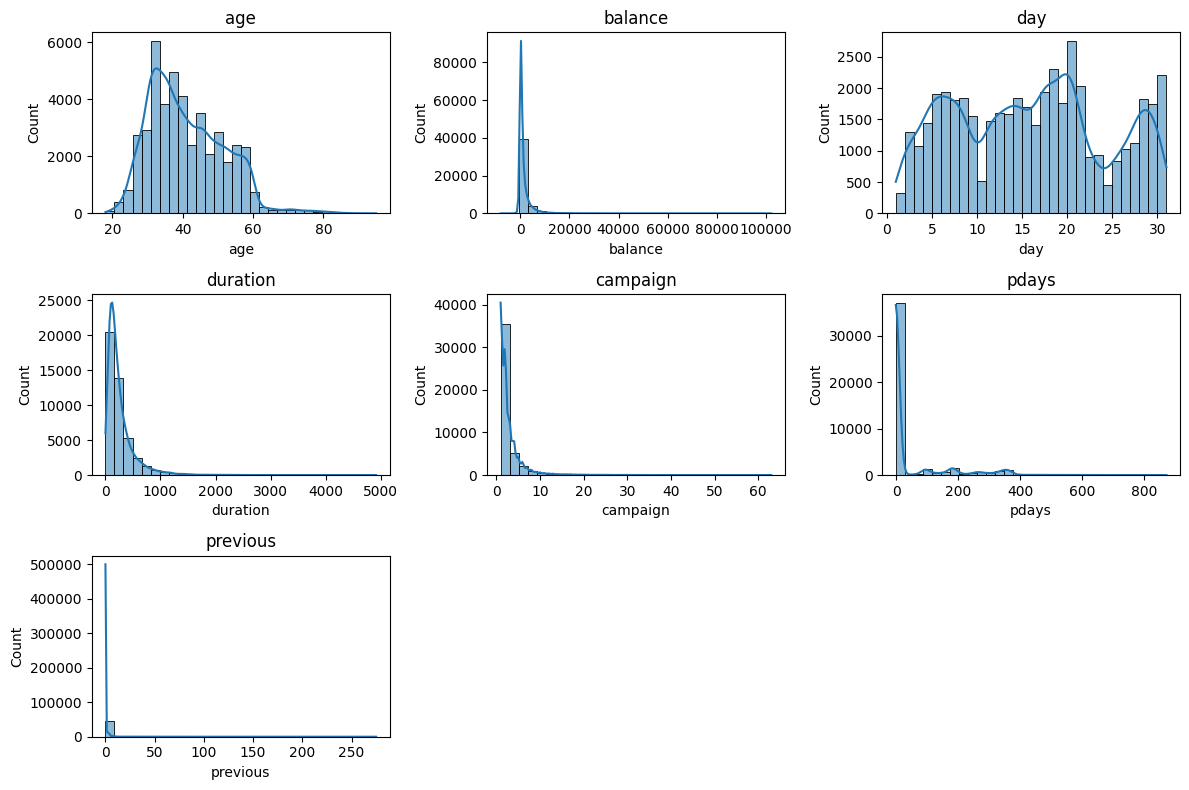

In [18]:
# Distribution
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[col], bins=30, kde=True)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

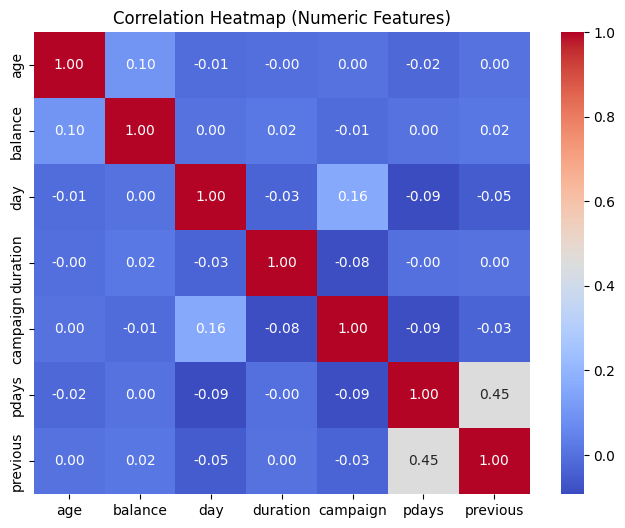

In [19]:
# Correlation
corr = df_train[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


We are trying to understand the numerical features in this section:
- How are the features distributed? Do they show any skewness?
- What are the correlations among the features?
- This will help us make better judgments on whether remove outliers, normalize, or remove similar features.

From the box plot and the distribution graphs
- Age       : that looks ok, with outliers
- Balance   : most people fill in 0, maybe people over look this section
- Day       : no outliers, good distribution
- Duration  : dropped due to data leakage
- Campaign  : more than 6 calls during a campain and that would be too many call for one personm > skewed right
- Pdays = contacted_before + pdays_numeric bc -1 means client was not previously contacted, there are too many -1 (81.7%) > skewed right
- Previous  : most clients are new (81.7%) > skewed right

Notes:
- From the correlation heatmap, most features are not correlated to anothers so we can keep them all

Actions
- Age           : StandardScaler
- Balance       : Skewed right with negative values > StandardScaler
- Day           : StandardScaler
- Campaign      : log1p transformed > StandardScaler
- pdays_numeric : log1p transformed > StandardScaler
- previous      : log1p transformed > StandardScaler

What is log1p transform?
- Reduces skewness
- Makes the distribution more normal-like
- Helps with logistic regression

## Categorical features

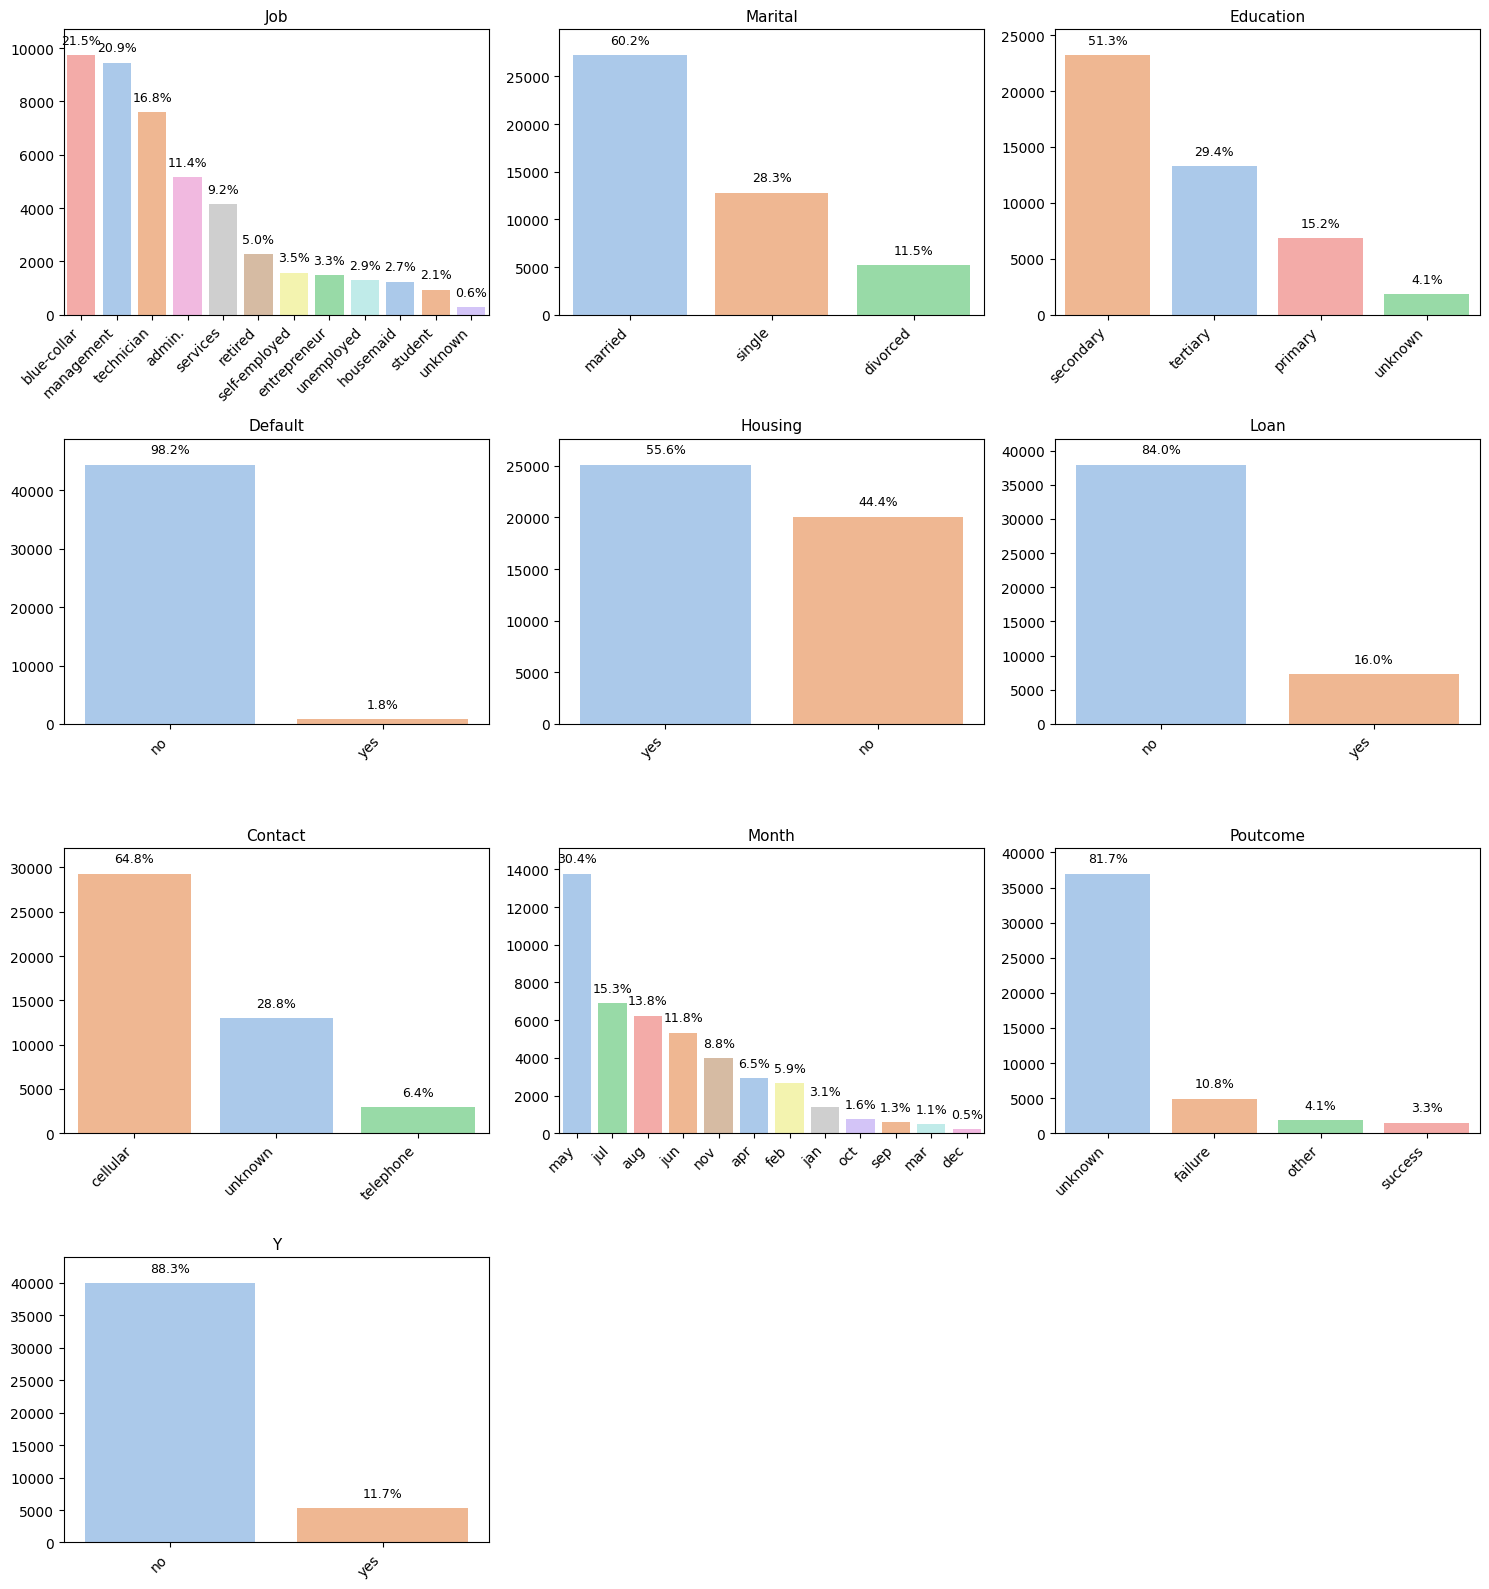

In [22]:
# Graphs
# Number of plots
n     = len(categorical_cols)             # 10
ncols = 3                         # 3 columns
nrows = n // ncols + 1            # 10 // 3 + 1 = 4

plt.figure(figsize=(5*ncols, 4*nrows))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(nrows, ncols, i)
    ax = sns.countplot(
        x=col,
        hue=col,
        data=df_train,
        palette='pastel',
        order=df_train[col].value_counts().index,
        legend=False
    )

    total = len(df_train)

    # find tallest bar to give extra y-axis space
    max_height = max(p.get_height() for p in ax.patches)
    ax.set_ylim(0, max_height * 1.10)  # 15% space above bars

    # annotate each bar
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total

        # annotate text slightly above bar top
        ax.annotate(
            f'{percentage:.1f}%',
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xytext=(0, 6),                  # 6 points above the bar
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

    plt.title(col.capitalize(), fontsize=11)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

From the bar charts:
- There are some dominant responses among the features; during training, the classes(freatures) will therefore be weighted.

What is Cramér’s V correlation coefficient?
- It measures the strength of association between two categorical variables.


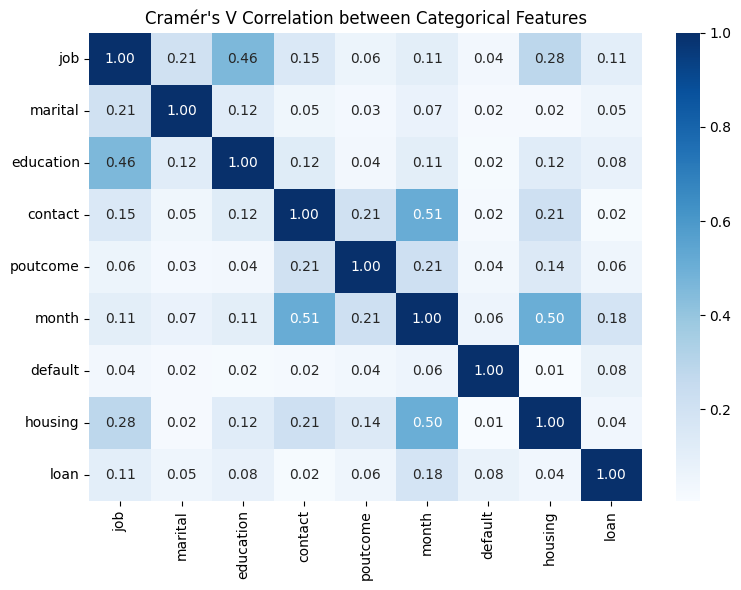

In [ ]:


def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2  = chi2_contingency(table, correction=False)[0]
    n     = table.sum().sum()
    k     = min(table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

# build the matrix
cramers = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

for c1 in cat_cols:
    for c2 in cat_cols:
        cramers.loc[c1, c2] = cramers_v(df[c1], df[c2])

# visualize
plt.figure(figsize=(8,6))
sns.heatmap(cramers.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title("Cramér's V Correlation between Categorical Features")
plt.tight_layout()
plt.show()


From the Cramer's V heat map
- There is no strong correlation among features
- 0.5 and 0.46 are the two most significant values
- education and job are kind of related - if you are in school > you are a student
- month and housing - in the summer, people are just happy to go buy a house
- month and contact - in the summer, people are just happy to pickup the phone

### Tranformation overview

In [ ]:
# 01. age       - numeric     - StandardScaler
# 02. job       - categorical - One-hot encoding
# 03. marital   - categorical - One-hot encoding
# 04. education - categorical - One-hot encoding
# 05. default   - binary      - Convert to 0/1
# 06. balance   - numeric     - StandardScaler
# 07. housing   - binary      - Convert to 0/1
# 08. loan      - binary      - Convert to 0/1
#
# 09. contact   - categorical - One-hot encoding
# 10. day       - numeric     - StandardScaler
# 11. month     - numeric     - One-hot encoding
# 12. duration  - numeric     - drop
#
# 13. campaign  - numeric     - Transform (log1p) - StandardScaler
# 14. pdays     - numeric     - contacted_before  - binary            - Convert to 0/1
#                             - pdays_numeric     - replace -1 with 0 - Transform (log1p) - StandardScaler

# 15. previous  - numeric     - Transform (log1p) - StandardScaler
# 16. poutcome  - categorical - One-hot encoding
# 17. y         - binary      - Convert to 0/1

In [ ]:
# Setup
print(df.head(1))
print('')
print('------Numeric columns------')
print(numeric_cols)

   age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome   y  
0    5   may       261         1     -1         0  unknown  no  

------Numeric columns------
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
# Replacing pdays with contacted_before + pdays_numeric
df['contacted_before']  = (df['pdays'] != -1).astype(int)
df['pdays_numeric']     = df['pdays'].replace(-1, 0)

In [ ]:
print(df.head(1))

   age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome   y  \
0    5   may       261         1     -1         0  unknown  no   

   contacted_before  pdays_numeric  
0                 0              0  


In [ ]:
# Make a new copy
df_scaled = df.copy()

### Numeric columns

In [ ]:
# Replacing pdays with pdays numeric
df_scaled     = df_scaled.drop('pdays', axis=1)
df_scaled     = df_scaled.drop('duration', axis=1)
numeric_cols  = ['age','balance','day','campaign','pdays_numeric','previous']
print(df_scaled.head(1))

   age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  campaign  previous poutcome   y  contacted_before  pdays_numeric  
0    5   may         1         0  unknown  no                 0              0  


In [ ]:
df_no_scaled  = df_scaled.copy()

In [ ]:
# 01. age       - numeric     - StandardScaler
# 06. balance   - numeric     - StandardScaler
# 10. day       - numeric     - StandardScaler
# 13. campaign  - numeric     - Transform (log1p) - StandardScaler
#                             - pdays_numeric     - Transform (log1p) - StandardScaler
# 15. previous  - numeric     - Transform (log1p) - StandardScaler

# Log + StandardScalor transforms
log_transform_cols            = ['campaign', 'pdays_numeric', 'previous']
df_scaled[log_transform_cols] = np.log1p(df_scaled[log_transform_cols])
scaler                        = StandardScaler()
df_scaled[numeric_cols]       = scaler.fit_transform(df_scaled[numeric_cols])

In [ ]:
print(df_scaled.head(1))
print(df_no_scaled.head(1))

        age         job  marital education default   balance housing loan  \
0  1.606965  management  married  tertiary      no  0.256419     yes   no   

   contact       day month  campaign  previous poutcome   y  contacted_before  \
0  unknown -1.298476   may -0.909457 -0.424616  unknown  no                 0   

   pdays_numeric  
0      -0.467314  
   age         job  marital education default  balance housing loan  contact  \
0   58  management  married  tertiary      no     2143     yes   no  unknown   

   day month  campaign  previous poutcome   y  contacted_before  pdays_numeric  
0    5   may         1         0  unknown  no                 0              0  


### Categorical columns

In [ ]:
# Convert to 0 and 1
# 05. default   - binary      - Convert to 0/1
# 07. housing   - binary      - Convert to 0/1
# 08. loan      - binary      - Convert to 0/1
# 17. y         - binary      - Convert to 0/1

df_scaled['default'] = df_scaled['default'].map({'yes': 1, 'no': 0})
df_scaled['housing'] = df_scaled['housing'].map({'yes': 1, 'no': 0})
df_scaled['loan']    = df_scaled['loan'].map({'yes': 1, 'no': 0})
df_scaled['y']       = df_scaled['y'].map({'yes': 1, 'no': 0})

df_no_scaled['default'] = df_no_scaled['default'].map({'yes': 1, 'no': 0})
df_no_scaled['housing'] = df_no_scaled['housing'].map({'yes': 1, 'no': 0})
df_no_scaled['loan']    = df_no_scaled['loan'].map({'yes': 1, 'no': 0})
df_no_scaled['y']       = df_no_scaled['y'].map({'yes': 1, 'no': 0})

In [ ]:
# 02. job       - categorical - One-hot encoding
# 03. marital   - categorical - One-hot encoding
# 04. education - categorical - One-hot encoding
# 09. contact   - categorical - One-hot encoding
# 11. month     - numeric     - One-hot encoding
# 16. poutcome  - categorical - One-hot encoding

one_hot_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

# One-hot encode only those columns
df_scaled = pd.get_dummies(df_scaled, columns=one_hot_cols, drop_first=False, dtype=int)
df_no_scaled = pd.get_dummies(df_no_scaled, columns=one_hot_cols, drop_first=False, dtype=int)

In [ ]:
df_scaled.info
df_no_scaled.info

<bound method DataFrame.info of        age  default  balance  housing  loan  day  campaign  previous  y  \
0       58        0     2143        1     0    5         1         0  0   
1       44        0       29        1     0    5         1         0  0   
2       33        0        2        1     1    5         1         0  0   
3       47        0     1506        1     0    5         1         0  0   
4       33        0        1        0     0    5         1         0  0   
...    ...      ...      ...      ...   ...  ...       ...       ... ..   
45206   51        0      825        0     0   17         3         0  1   
45207   71        0     1729        0     0   17         2         0  1   
45208   72        0     5715        0     0   17         5         3  1   
45209   57        0      668        0     0   17         4         0  0   
45210   37        0     2971        0     0   17         2        11  0   

       contacted_before  ...  month_jun  month_mar  month_may  month_nov  \
0                     0  ...          0          0          1          0   
1                     0  ...          0          0          1          0   
2                     0  ...          0          0          1          0   
3                     0  ...          0          0          1          0   
4                     0  ...          0          0          1          0   
...                 ...  ...        ...        ...        ...        ...   
45206                 0  ...          0          0          0          1   
45207                 0  ...          0          0          0          1   
45208                 1  ...          0          0          0          1   
45209                 0  ...          0          0          0          1   
45210                 1  ...          0          0          0          1   

       month_oct  month_sep  poutcome_failure  poutcome_other  \
0              0          0                 0               0   
1              0          0                 0               0   
2              0          0                 0               0   
3              0          0                 0               0   
4              0          0                 0               0   
...          ...        ...               ...             ...   
45206          0          0                 0               0   
45207          0          0                 0               0   
45208          0          0                 0               0   
45209          0          0                 0               0   
45210          0          0                 0               1   

       poutcome_success  poutcome_unknown  
0                     0                 1  
1                     0                 1  
2                     0                 1  
3                     0                 1  
4                     0                 1  
...                 ...               ...  
45206                 0                 1  
45207                 0                 1  
45208                 1                 0  
45209                 0                 1  
45210                 0                 0  

[45211 rows x 49 columns]>

In [ ]:
# Export to cvs
df_scaled.to_csv('L_N_train.csv', index=False)
df_no_scaled.to_csv('R_X_train.csv', index=False)

df_scaled
- This is used for Logistic Regression and Naive Bayes. Both require every feature to be either scaled, normalized, converted to binary, or one-hot encoded.

df_no_scaled
- This is used for Random Forest and XGBoost. The numerical attributes are not scaled for these two models; however, all other preprocessing steps still apply — converting to binary and one-hot encoding.

# **Section 2: Fit models**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
  make_scorer,
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

import pandas as pd



In [ ]:
# Load Training Data
df_L_N_train = pd.read_csv("L_N_train.csv")
df_R_X_train = pd.read_csv("R_X_train.csv")

In [ ]:
def run_cv(model, df: pd.DataFrame, target: str, name: str, cv=5):

    df = df.copy()
    y  = df[target]
    X  = df.drop(columns=[target])

    scoring = {
        "accuracy" : make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall"   : make_scorer(recall_score),
        "f1"       : make_scorer(f1_score),
        "auc"      : 'roc_auc',
    }

    # Stratified keeps the class (yes/no) proportions the same in every fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    cvres = cross_validate(
        model, X, y,
        scoring = scoring,
        cv      = skf,
    )

    return dict(
        Model     = name,
        Accuracy  = cvres["test_accuracy"].mean(),
        Precision = cvres["test_precision"].mean(),
        Recall    = cvres["test_recall"].mean(),
        F1        = cvres["test_f1"].mean(),
        AUC       = cvres["test_auc"].mean(),
    )

In [ ]:
# Models
log_reg = LogisticRegression(
    class_weight= "balanced",
    max_iter    = 1000,
    solver      = "lbfgs",
)

gnb = GaussianNB()

rf = RandomForestClassifier(
    class_weight  = "balanced",
    random_state  = 42,
)

xgb = XGBClassifier(
    scale_pos_weight  = 7.548,
    random_state      = 42,
    eval_metric       = "logloss",
    tree_method       = "hist"
)

In [ ]:
results = []

for name, model in [
  ("Logistic Regression", log_reg),
  ("Naive Bayes", gnb),
  ("Random Forest", rf),
  ("XGBoost", xgb)
]:
  if name in ["Logistic Regression", "Naive Bayes"]:
    metrics = run_cv(model, df_L_N_train, 'y', name)
  else:
    metrics = run_cv(model, df_R_X_train, 'y', name)
  results.append(metrics)

# Create comparison table
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(df_results)

                 Model  Accuracy  Precision    Recall        F1       AUC
3              XGBoost  0.829223   0.358180  0.579887  0.442756  0.779178
1          Naive Bayes  0.827763   0.327613  0.449046  0.378778  0.737421
0  Logistic Regression  0.757515   0.268765  0.623371  0.375576  0.766589
2        Random Forest  0.894251   0.643790  0.214785  0.321968  0.782856


# GaussianNB - Hoan Lam

### Load Data

In [ ]:
df_L_N_train = pd.read_csv("L_N_train.csv")

In [ ]:
display(df_L_N_train.shape)
df_L_N_train.head()

(45211, 49)

,age,default,balance,housing,loan,day,campaign,previous,y,contacted_before,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0,0.256419,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,0,-0.437895,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,0,-0.446762,1,1,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0,0.047205,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,0,-0.447091,0,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1


### Helpers

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
# IAMB implementation with partial correlation
# def iamb

# Credited
# https://dev.to/ogambakerubo/feature-selection-with-the-iamb-algorithm-a-casual-dive-into-machine-learning-53a7

import pingouin as pg

def iamb(data, target, alpha=0.05):

  markov_blanket = set()

  # Forward Phase
  for feature in data.columns:
    if feature != target:

      # partial_corr
      # ex:
      #            n         r         CI95%         p-val
      # pearson  768  0.221898  [0.15, 0.29]  5.065127e-10
      #
      # n     - number of valid samples used
      # r     - partial correlations strength
      # CI95% - 95% confidence interval for r
      # p-val - Probability that the observed r occurred by chance if there's no real relationship

      partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=markov_blanket)
      p_value       = partial_corr['p-val'].iloc[0]

      # p-value > 0.05 - Could just be randome noise > Ignore feature
      # p-value < 0.05 - Probably meaningful > Keep feature
      if p_value < alpha:
        markov_blanket.add(feature)

  print("Selected Features after Forward Phase :", markov_blanket)

  # Backward Phase
  for feature in list(markov_blanket):
    reduced_mb    = markov_blanket - {feature}
    partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=reduced_mb)
    p_value       = partial_corr['p-val'].iloc[0]
    if p_value > alpha:
      markov_blanket.remove(feature)

  print("Selected Features after Backward Phase :", markov_blanket)
  return list(markov_blanket)


# Run cross validation
def run_cv(model, X, y, name: str, cv=5):
  scoring = {
    "accuracy" : make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall"   : make_scorer(recall_score),
    "f1"       : make_scorer(f1_score),
    "auc"      : "roc_auc",
  }

  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

  cvres = cross_validate(
    model, X, y,
    scoring = scoring,
    cv      = skf,
  )

  return dict(
    Model     = name,
    Accuracy  = cvres["test_accuracy"].mean(),
    Precision = cvres["test_precision"].mean(),
    Recall    = cvres["test_recall"].mean(),
    F1        = cvres["test_f1"].mean(),
    AUC       = cvres["test_auc"].mean(),
  )

### Apply IAMB

In [ ]:
selected_features = iamb(df_L_N_train, 'y', alpha=0.05)

Selected Features after Forward Phase : {'month_jan', 'default', 'campaign', 'poutcome_other', 'loan', 'pdays_numeric', 'month_jun', 'job_blue-collar', 'balance', 'month_apr', 'poutcome_success', 'job_technician', 'job_housemaid', 'marital_married', 'education_tertiary', 'job_student', 'poutcome_failure', 'job_unknown', 'month_mar', 'job_retired', 'education_primary', 'month_aug', 'previous', 'age', 'contact_cellular', 'marital_single', 'contact_unknown', 'contacted_before', 'day', 'job_services', 'month_jul', 'month_nov', 'month_dec', 'housing', 'job_entrepreneur', 'month_feb', 'month_may', 'contact_telephone', 'education_secondary'}
Selected Features after Backward Phase : {'month_jan', 'campaign', 'loan', 'pdays_numeric', 'month_jun', 'balance', 'month_apr', 'poutcome_success', 'job_housemaid', 'marital_married', 'job_student', 'poutcome_failure', 'month_mar', 'job_retired', 'education_primary', 'month_aug', 'previous', 'contact_cellular', 'contact_unknown', 'contacted_before', 'day

In [ ]:
new_df_L_N_train = df_L_N_train[selected_features].assign(y=df_L_N_train['y'])

In [ ]:
# IAMB results - 49 features > 28 features

In [ ]:
display(df_L_N_train.shape)
df_L_N_train.head()

(45211, 49)

,age,default,balance,housing,loan,day,campaign,previous,y,contacted_before,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0,0.256419,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,0,-0.437895,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,0,-0.446762,1,1,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0,0.047205,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,0,-0.447091,0,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
display(new_df_L_N_train.shape)
new_df_L_N_train.head()

(45211, 29)

,month_jan,campaign,loan,pdays_numeric,month_jun,balance,month_apr,poutcome_success,job_housemaid,marital_married,...,contacted_before,day,month_jul,month_nov,housing,month_feb,month_may,contact_telephone,education_secondary,y
0,0,-0.909457,0,-0.467314,0,0.256419,0,0,0,1,...,0,-1.298476,0,0,1,0,1,0,0,0
1,0,-0.909457,0,-0.467314,0,-0.437895,0,0,0,0,...,0,-1.298476,0,0,1,0,1,0,1,0
2,0,-0.909457,1,-0.467314,0,-0.446762,0,0,0,1,...,0,-1.298476,0,0,1,0,1,0,1,0
3,0,-0.909457,0,-0.467314,0,0.047205,0,0,0,1,...,0,-1.298476,0,0,1,0,1,0,0,0
4,0,-0.909457,0,-0.467314,0,-0.447091,0,0,0,0,...,0,-1.298476,0,0,0,0,1,0,0,0


### Checking if test.csv a subset of train.csv - It is sadly

In [ ]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [ ]:
is_subset = test.merge(train.drop_duplicates(), how="left", indicator=True)["_merge"].eq("both").all()
print("Test ⊆ Train ?", is_subset)

Test ⊆ Train ? True


### Since test.csv is a subset of train.csv > going to split the training into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X = df_L_N_train.drop('y', axis=1)
y = df_L_N_train['y']

X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y          # this ensures the class proportion in train and test matches the original
)

X_train_selected  = X_train[selected_features]
X_test_selected   = X_test[selected_features]

### GaussianNB Models

In [ ]:
gnb_1 = GaussianNB()  # ALl features
gnb_2 = GaussianNB()  # Selected features

### Cross validation to average results

In [ ]:
results = []
for name, model in [
  ("Naive Bayes", gnb_1),
  ("Naive Bayes IAMB", gnb_2),

]:
  if name in ["Naive Bayes"]:
    metrics = run_cv(model, X_train, y_train, name)
  else:
    metrics = run_cv(model, X_train_selected, y_train, name)
  results.append(metrics)

# Create comparison table
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(df_results)

              Model  Accuracy  Precision    Recall        F1       AUC
0       Naive Bayes  0.826808   0.324785  0.445961  0.375602  0.735862
1  Naive Bayes IAMB  0.826619   0.311553  0.398693  0.349633  0.727091


### Models to test on the test set

In [ ]:
from sklearn.metrics import roc_auc_score

# Model with All Features
model_all   = gnb_1
model_all.fit(X_train, y_train)
y_pred_all  = model_all.predict(X_test)

# Model with IAMB-Selected Features
model_iamb  = gnb_2
model_iamb.fit(X_train_selected, y_train)
y_pred_iamb = model_iamb.predict(X_test_selected)

# Evaluate models
results = {
  'Model'   : ['Naive Bayes', 'Naive Bayes IAMB'],
  'Accuracy': [accuracy_score(y_test, y_pred_all), accuracy_score(y_test, y_pred_iamb)],
  'F1 Score': [f1_score(y_test, y_pred_all), f1_score(y_test, y_pred_iamb)],
  'AUC-ROC' : [roc_auc_score(y_test, model_all.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, model_iamb.predict_proba(X_test_selected)[:, 1]),]
}

results_df = pd.DataFrame(results)
print(results_df)

              Model  Accuracy  F1 Score   AUC-ROC
0       Naive Bayes  0.828517  0.382369  0.740632
1  Naive Bayes IAMB  0.830139  0.361419  0.736056
